In [58]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras import optimizers

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Model Definition

In [59]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
            

In [60]:
class VAE:
    def __init__(self, x_dim, z_dim):
        self.inputs, self.q_graph, self.z_mean, self.z_log_var = self.constructq_graph(x_dim, z_dim)
        self.p_graph = self.constructp_graph(x_dim, z_dim)
        self.outputs = self.p_graph(self.q_graph(self.inputs)[2])
        self.vae = Model(self.inputs, self.outputs)
        
    def constructq_graph(self, x_dim, z_dim):
        inputs = Input(shape = (x_dim,))
        x = Dense( 256, activation='relu')(inputs)
        z_mean = Dense(z_dim)(x)
        z_log_var = Dense(z_dim)(x)
        z = Lambda(sampling, output_shape=(z_dim,))([z_mean, z_log_var])
        q_graph = Model(inputs, [z_mean, z_log_var, z])
        
        return inputs, q_graph, z_mean, z_log_var
    
    def constructp_graph(self, x_dim, z_dim):
        latent_inputs = Input(shape=(z_dim,))
        x = Dense( 256, activation='relu')(latent_inputs)
        outputs = Dense(x_dim, activation='sigmoid')(x)
        p_graph = Model(latent_inputs, outputs)
        
        return p_graph

In [61]:
vae_2 = VAE(784, 2)     #z-dim = 2
vae_8 = VAE(784, 8)     #z-dim = 8
vae_16 = VAE(784, 16)    #z-dim = 16


In [62]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255



In [63]:
reconstruction_loss = mse(vae_2.inputs, vae_2.outputs)
reconstruction_loss *= original_dim
kl_loss = -0.5*K.sum(1 + vae_2.z_log_var - K.square(vae_2.z_mean) - K.exp(vae_2.z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae_2.vae.add_loss(vae_loss)
adam = optimizers.Adam()
vae_2.vae.compile(optimizer=adam)

In [ ]:
vae_2.vae.fit(x_train,
             epochs=50,
             batch_size=128)
vae_2.vae.save_weights('./vae_2.h5')

Epoch 1/50
60000/60000 [==============================] - 12s 199us/step - loss: 54.8254
Epoch 2/50
60000/60000 [==============================] - 10s 174us/step - loss: 44.0935
Epoch 3/50
60000/60000 [==============================] - 10s 172us/step - loss: 43.0877
Epoch 4/50
60000/60000 [==============================] - 10s 168us/step - loss: 42.4003
Epoch 5/50
60000/60000 [==============================] - 11s 176us/step - loss: 41.8612
Epoch 6/50
60000/60000 [==============================] - 11s 181us/step - loss: 41.4687
Epoch 7/50
60000/60000 [==============================] - 11s 176us/step - loss: 41.1335
Epoch 8/50
60000/60000 [==============================] - 11s 178us/step - loss: 40.8820
Epoch 9/50
60000/60000 [==============================] - 11s 180us/step - loss: 40.6406
Epoch 10/50
60000/60000 [==============================] - 11s 176us/step - loss: 40.4323
Epoch 11/50
60000/60000 [==============================] - 11s 179us/step - loss: 40.2451
Epoch 12/50
60000/6

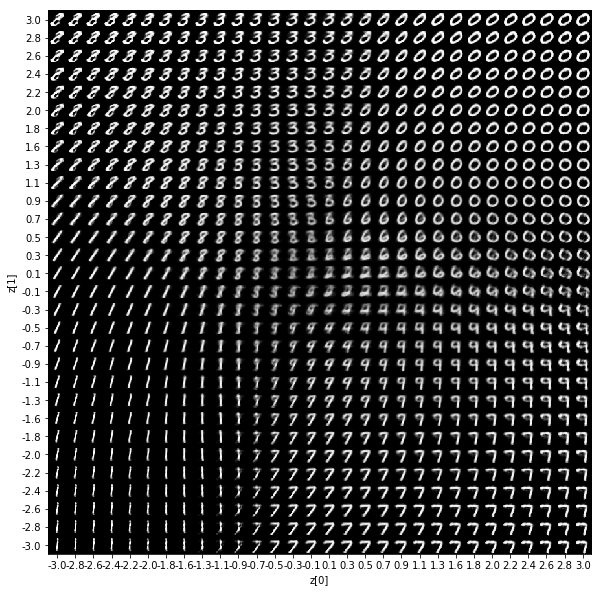

In [57]:
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae_2.p_graph.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = (n - 1) * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='Greys_r')
plt.savefig('./vae_2_interpolation.jpg')
plt.show()